In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [3]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/Data/Brain/archive.zip") as f:
    f.extractall("Untitled Folder")

In [4]:
train_dir = "Untitled Folder/Training/"
test_dir = "Untitled Folder/Testing"
num_classes = len(os.listdir(train_dir))
img_size = 128
class_labels = ['glioma','notumor','meningioma','pituitary']

In [5]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + '/' + target_class

    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder + '/' + random_image[0])

    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"shape: {img.shape}")

    return img


shape: (512, 512)
shape: (630, 630, 3)
shape: (512, 512)
shape: (512, 512, 3)


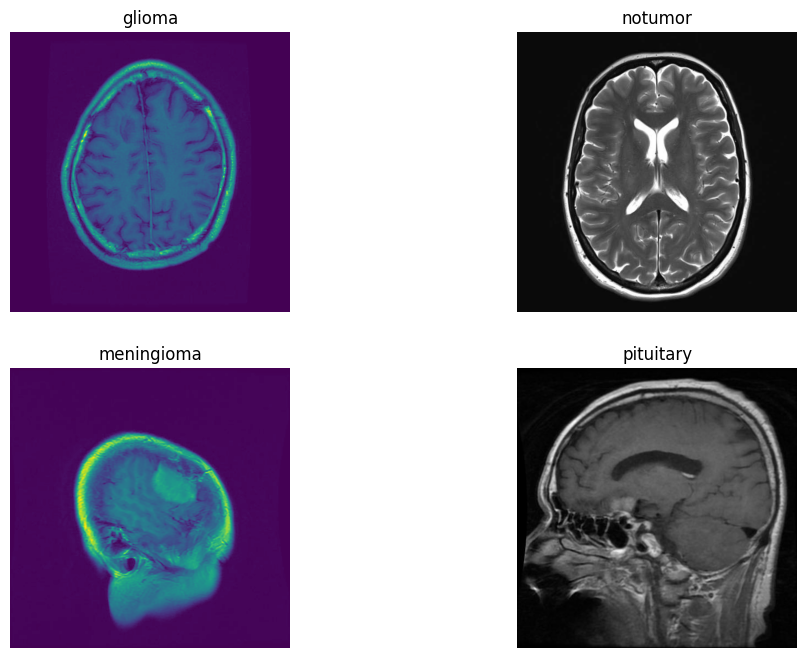

In [6]:

plt.figure(figsize=(12,8))
for i in range(0,4):
    plt.subplot(2, 2, i+1)
    img = view_random_image(train_dir, class_labels[i])


In [79]:
X = []
y = []

for class_label in class_labels:
    folder_path = os.path.join(train_dir, class_label)
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        X.append(image)
        y.append(class_label)

for class_label in class_labels:
    folder_path = os.path.join(test_dir, class_label)
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        X.append(image)
        y.append(class_label)

X = np.array(X)
y = np.array(y)


In [80]:
X.shape, y.shape

((7023, 128, 128, 3), (7023,))

In [9]:
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# X_train.shape, y_train_encoded.shape


((7023, 128, 128, 3), (7023,))

In [32]:
y = y.reshape(-1,1)
one_hot = OneHotEncoder()
y_encoded = one_hot.fit_transform(ycpy)
X.shape, y_encoded.shape

((7023, 128, 128, 3), (7023, 4))

In [36]:
y_encoded_array = y_encoded.toarray()

In [37]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y_encoded_array, test_size=0.1, random_state=101, shuffle=True)

In [38]:
X_train_final.shape , X_test_final.shape , y_train_final.shape , y_test_final.shape

((6320, 128, 128, 3), (703, 128, 128, 3), (6320, 4), (703, 4))

In [39]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

model = inception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=inception.input, outputs = model)

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


history = model.fit(X_train_final,y_train_final,validation_split=0.1, epochs =8, verbose=1, batch_size=32)

Epoch 1/8
178/178 [==============================] - 53s 99ms/step - loss: 0.4081 - accuracy: 0.8662 - val_loss: 1.2661 - val_accuracy: 0.7104
Epoch 2/8
178/178 [==============================] - 16s 91ms/step - loss: 0.2272 - accuracy: 0.9270 - val_loss: 30.9913 - val_accuracy: 0.3339
Epoch 3/8
178/178 [==============================] - 16s 91ms/step - loss: 0.2267 - accuracy: 0.9327 - val_loss: 0.3238 - val_accuracy: 0.9051
Epoch 4/8
178/178 [==============================] - 16s 91ms/step - loss: 0.0940 - accuracy: 0.9673 - val_loss: 0.3025 - val_accuracy: 0.9177
Epoch 5/8
178/178 [==============================] - 16s 90ms/step - loss: 0.0575 - accuracy: 0.9828 - val_loss: 0.2702 - val_accuracy: 0.9114
Epoch 6/8
178/178 [==============================] - 16s 90ms/step - loss: 0.0813 - accuracy: 0.9740 - val_loss: 0.4620 - val_accuracy: 0.8845
Epoch 7/8
178/178 [==============================] - 16s 89ms/step - loss: 0.0572 - accuracy: 0.9815 - val_loss: 0.2950 - val_accuracy: 0.895

In [42]:
def plot(history_df):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
  ax[0].plot(history_df['loss'], label='Training Loss')
  ax[0].plot(history_df['val_loss'], label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].legend()

  ax[1].plot(history_df['accuracy'], label='Training Accuracy')
  ax[1].plot(history_df['val_accuracy'], label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].legend()

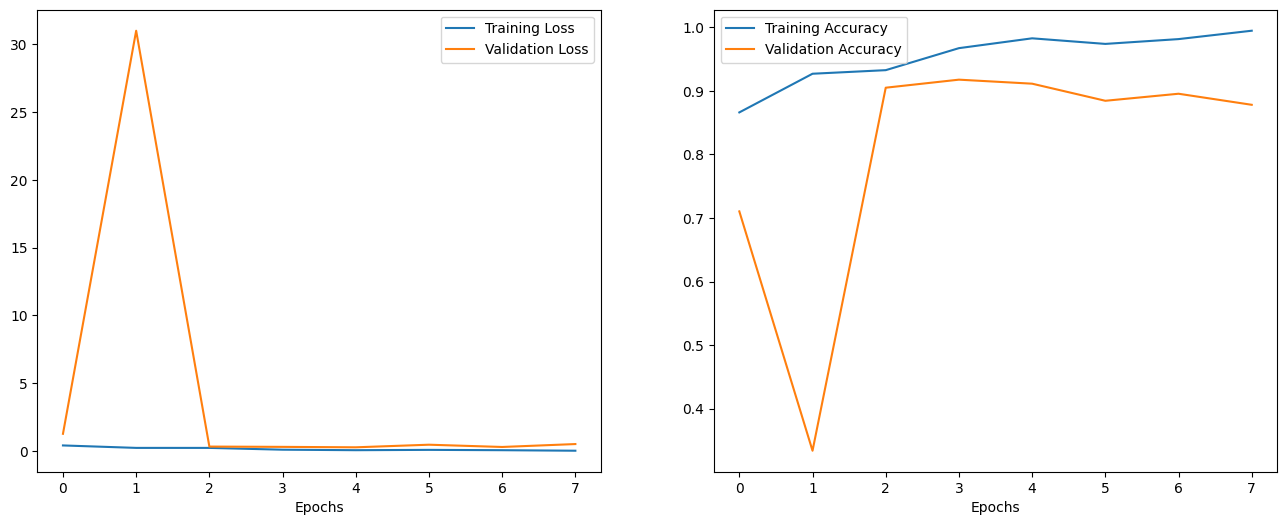

In [43]:
history_df = pd.DataFrame(history.history)

plot(history_df)

In [44]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

model_2 = resnet.output
model_2 = tf.keras.layers.GlobalAveragePooling2D()(model_2)
model_2 = tf.keras.layers.Dropout(rate=0.5)(model_2)
model_2 = tf.keras.layers.Dense(4,activation='softmax')(model_2)
model_2 = tf.keras.models.Model(inputs=resnet.input, outputs = model_2)

model_2.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


history_2 = model_2.fit(X_train_final,y_train_final,validation_split=0.1, epochs =15, verbose=1, batch_size=32)

Epoch 1/15
178/178 [==============================] - 54s 100ms/step - loss: 0.3785 - accuracy: 0.8659 - val_loss: 0.7476 - val_accuracy: 0.8228
Epoch 2/15
178/178 [==============================] - 16s 92ms/step - loss: 0.1774 - accuracy: 0.9459 - val_loss: 1.5503 - val_accuracy: 0.6108
Epoch 3/15
178/178 [==============================] - 16s 90ms/step - loss: 0.1055 - accuracy: 0.9650 - val_loss: 0.1656 - val_accuracy: 0.9494
Epoch 4/15
178/178 [==============================] - 16s 89ms/step - loss: 0.1153 - accuracy: 0.9631 - val_loss: 0.4473 - val_accuracy: 0.8339
Epoch 5/15
178/178 [==============================] - 17s 93ms/step - loss: 0.0618 - accuracy: 0.9801 - val_loss: 0.3841 - val_accuracy: 0.8782
Epoch 6/15
178/178 [==============================] - 17s 97ms/step - loss: 0.1610 - accuracy: 0.9532 - val_loss: 0.8782 - val_accuracy: 0.7041
Epoch 7/15
178/178 [==============================] - 17s 94ms/step - loss: 0.0932 - accuracy: 0.9675 - val_loss: 0.1976 - val_accuracy

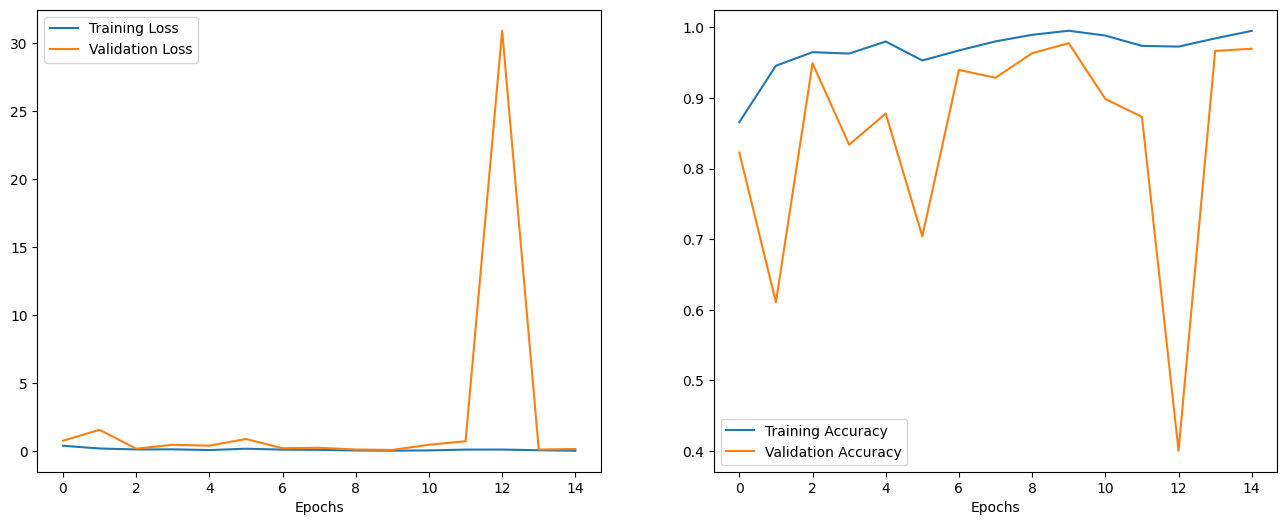

In [45]:
history_df_2 = pd.DataFrame(history_2.history)
plot(history_df_2)

In [49]:
from tensorflow.keras.applications.xception import Xception

xception = Xception(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

model_3 = xception.output
model_3 = tf.keras.layers.GlobalAveragePooling2D()(model_3)
model_3 = tf.keras.layers.Dropout(rate=0.5)(model_3)
model_3 = tf.keras.layers.Dense(4,activation='softmax')(model_3)
model_3 = tf.keras.models.Model(inputs=xception.input, outputs = model_3)

model_3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


history_3 = model_3.fit(X_train_final,y_train_final,validation_split=0.1, epochs =10, verbose=1, batch_size=32)

Epoch 1/10
178/178 [==============================] - 57s 174ms/step - loss: 0.3360 - accuracy: 0.8878 - val_loss: 1.6668 - val_accuracy: 0.8623
Epoch 2/10
178/178 [==============================] - 30s 170ms/step - loss: 0.1398 - accuracy: 0.9539 - val_loss: 0.8141 - val_accuracy: 0.8196
Epoch 3/10
178/178 [==============================] - 29s 166ms/step - loss: 0.0775 - accuracy: 0.9742 - val_loss: 0.1349 - val_accuracy: 0.9652
Epoch 4/10
178/178 [==============================] - 30s 170ms/step - loss: 0.0852 - accuracy: 0.9729 - val_loss: 0.3367 - val_accuracy: 0.8972
Epoch 5/10
178/178 [==============================] - 30s 170ms/step - loss: 0.0495 - accuracy: 0.9852 - val_loss: 0.1907 - val_accuracy: 0.9367
Epoch 6/10
178/178 [==============================] - 31s 172ms/step - loss: 0.0357 - accuracy: 0.9893 - val_loss: 0.1408 - val_accuracy: 0.9557
Epoch 7/10
178/178 [==============================] - 30s 169ms/step - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.0634 - val_ac

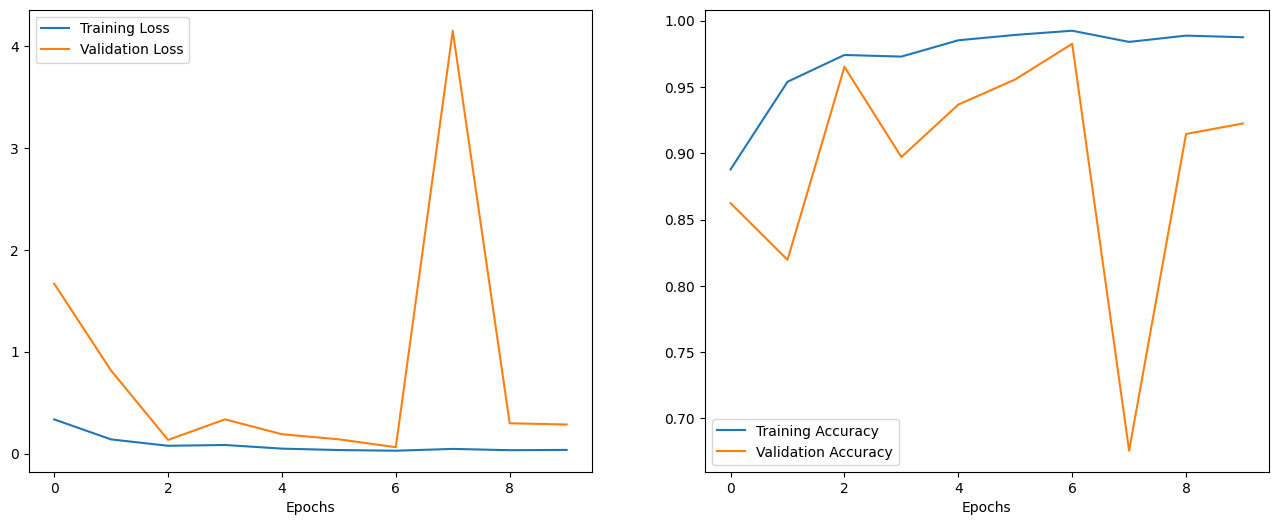

In [51]:
history_df_3 = pd.DataFrame(history_3.history)
plot(history_df_3)

In [57]:
### CHOOSING XCEPTION TF LEARNING MODEL WITH 7 EPOCHS
xception = Xception(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

model_final = xception.output
model_final = tf.keras.layers.GlobalAveragePooling2D()(model_final)
model_final = tf.keras.layers.Dropout(rate=0.5)(model_final)
model_final = tf.keras.layers.Dense(4,activation='softmax')(model_final)
model_final = tf.keras.models.Model(inputs=xception.input, outputs = model_final)

model_final.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


history_final = model_final.fit(X_train_final,y_train_final,validation_split=0.1, epochs =7, verbose=1, batch_size=32)

Epoch 1/7
178/178 [==============================] - 57s 175ms/step - loss: 0.3465 - accuracy: 0.8840 - val_loss: 0.6511 - val_accuracy: 0.8560
Epoch 2/7
178/178 [==============================] - 30s 169ms/step - loss: 0.1378 - accuracy: 0.9515 - val_loss: 0.4959 - val_accuracy: 0.8813
Epoch 3/7
178/178 [==============================] - 30s 166ms/step - loss: 0.0863 - accuracy: 0.9720 - val_loss: 0.2314 - val_accuracy: 0.9193
Epoch 4/7
178/178 [==============================] - 30s 168ms/step - loss: 0.0637 - accuracy: 0.9798 - val_loss: 0.6092 - val_accuracy: 0.8687
Epoch 5/7
178/178 [==============================] - 30s 170ms/step - loss: 0.0381 - accuracy: 0.9875 - val_loss: 0.1648 - val_accuracy: 0.9525
Epoch 6/7
178/178 [==============================] - 30s 167ms/step - loss: 0.0635 - accuracy: 0.9819 - val_loss: 0.2194 - val_accuracy: 0.9509
Epoch 7/7
178/178 [==============================] - 30s 170ms/step - loss: 0.0432 - accuracy: 0.9847 - val_loss: 0.0957 - val_accuracy:

In [58]:
##### PREDICTING WITH FINAL MODEL
y_pred = model_final.predict(X_test_final)

22/22 [==============================] - 2s 75ms/step


In [59]:
y_pred.shape

(703, 4)

In [60]:
y_train_final.shape

(6320, 4)

In [66]:
y_pred_labelencode = np.argmax(y_pred,axis=1)
y_test_final_labelencode = np.argmax(y_test_final,axis=1)

Text(0.5, 1.0, 'Confusion Matrix')

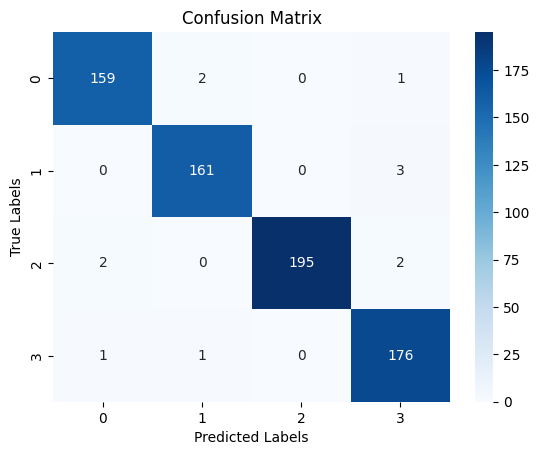

In [78]:
confusion_mat = confusion_matrix(y_test_final_labelencode, y_pred_labelencode)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# ['glioma','notumor','meningioma','pituitary']